https://adventuresinmachinelearning.com/word2vec-keras-tutorial/

https://towardsdatascience.com/a-word2vec-implementation-using-numpy-and-python-d256cf0e5f28

https://medium.com/@zafaralibagh6/a-simple-word2vec-tutorial-61e64e38a6a1

# Word2Vec: A language model implementation

Word2Vec is one of the most popular methods when doing language modelling, especially in the cases that we want the algorithm to be fast.

In this notebook, we will implement Word2Vec model and task from scratch, train it, and use the trained model to view similar words.

## Data Preprocessing

In [4]:
import keras
import requests
import zipfile
from tqdm import tqdm
from collections import Counter
import numpy as np

from keras.models import Model
from keras.layers import Input, Dense, Reshape, dot
from keras.layers.embeddings import Embedding
from keras.preprocessing.sequence import skipgrams
from keras.preprocessing import sequence

import tensorflow as tf
tf.config.run_functions_eagerly(True)


First, we download and extract the dataset we will be using.

In [5]:
def download_data():
    url = "http://mattmahoney.net/dc/text8.zip"
    r = requests.get(url, stream=True)
    
    bar = tqdm (
        total = int(r.headers["Content-Length"]),
        initial = 0,
        unit = 'B',
        unit_scale = True,
    )
    
    with open("data.zip", "wb") as f:
        for chunk in r.iter_content(chunk_size=1024):
            if chunk:
                f.write(chunk)
                bar.update(1024)
    bar.close()

In [6]:
def extract_data():
    zipfile.ZipFile("data.zip").extractall()

We get all of the words from our corpus file.

In [7]:
def fetch_words():
    words = []
    with open("text8", "r") as f:
        for line in f:
            for word in line.strip().split(" "):
                words.append(word)
                
    return words

Now we need to find the frequency of each word. 

We pick most frequent words (number of words = n_words below) and then we tokenize them. Tokenization is a indexing process. 

We also create reverse indexes to convert integer-type predictions to strings.


More technically: 
Indexing means a hash-table or dictionary where key is the word and reverse indexing is a hash-table where key is the index and value is the word. This is a one to one and onto relation. 



In addition, since we picked frequent words at start, not so frequent words will be labelled as "UNKNOWN", since we have little examples on them. These words might be person names, rarely used words, or other proper nouns like city names, country names...


In [8]:
def build_data(words, n_words):
    freq = [['UNKNOWN', -1]]
    
    c = Counter(words)
    pairs = list(c.items())
    pairs_filtered = sorted(pairs, key=lambda x: -x[1])[:n_words-1] 
    for word, count in pairs_filtered: 
        freq.append([word, count])
        
    dictionary = dict()
    for word, _ in freq:
        dictionary[word] = len(dictionary)
        
    data = list()
    unknown_count = 0
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0  # dictionary['UNKNOWN']
            unknown_count += 1
        data.append(index)
        
    freq[0][1] = unknown_count
    
    inverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return data, freq, dictionary, inverse_dictionary

We call our functions and retrieve processed word data.

In [9]:
download_data()
extract_data()
words = fetch_words()

vector_dim = 300
epochs = 200000
vocabulary_upper_limit = 10000
data, freq, dictionary, inverse_dictionary = build_data(words, vocabulary_upper_limit)

31.3MB [00:34, 917kB/s]                            


## Task Formulation

### Word2Vec Task: Skipgrams

A skipgram is where you get one word from a sentence inside your corpus, if another selected word is near it. Even though it is simple, skipgram task is an efficient and effective way to do language modelling.

(There is also the CBOW task, which we did not implement here. Check other sources for CBOW task) 

More technically:

A skipgram simply pairs a word with words with a distance of window_size this is a positive lookup and also for outer range pairs it is a negative lookup. Couples are the pairs and label is 1 or 0 according to positive or negative lookup.

In [10]:
sampling_table = sequence.make_sampling_table(vocabulary_upper_limit)
couples, labels = skipgrams(data, vocabulary_upper_limit, window_size=3, sampling_table=sampling_table)
word_target, word_context = zip(*couples)
word_target = np.array(word_target, dtype="int32")
word_context = np.array(word_context, dtype="int32")

Below one can find our model architecture. An embedding layer shared by target and context and later taking their dot product and passing trough a dense layer and output is whether it is a positive lookup or a negative one in other words 1 or 0.

## The Model

In [11]:
input_target, input_context = Input(shape=(1)), Input(shape=(1))

embedding = Embedding(vocabulary_upper_limit, vector_dim, input_length=1, name='embedding')

target = embedding(input_target)
target = Reshape((vector_dim, 1))(target)

context = embedding(input_context)
context = Reshape((vector_dim, 1))(context)

dot_product = dot([target, context],  axes=1)
dot_product = Reshape((1,))(dot_product)

output = Dense(1, activation='sigmoid')(dot_product)

model = Model(inputs=[input_target, input_context], outputs=output)
model.compile(loss='binary_crossentropy', optimizer='adam')

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 300)       3000000     input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
reshape (Reshape)               (None, 300, 1)       0           embedding[0][0]              

## Training and Saving the model

In [ ]:
batch_size = 4096
epochs = 2
for itr in range(epochs):
    for batch_num in range(len(word_target)//batch_size):
      myslice = slice(batch_num*batch_size,(batch_num+1)*batch_size)
  
      batch_inputs = np.array(word_target[myslice]).reshape(batch_size,1)
      batch_contexts = np.array(word_context[myslice]).reshape(batch_size,1)
      batch_labels = np.array(labels[myslice]).reshape(batch_size,1)

      loss = model.train_on_batch([batch_inputs,batch_contexts],batch_labels)
      print(f"Epoch: {itr}\tBatch Num:{batch_num}/{len(word_target)//batch_size}\tloss={loss}")

Streaming output truncated to the last 5000 lines.
Epoch: 1	Batch Num:2327/7327	loss=0.3961331248283386
Epoch: 1	Batch Num:2328/7327	loss=0.4009467661380768
Epoch: 1	Batch Num:2329/7327	loss=0.394375205039978
Epoch: 1	Batch Num:2330/7327	loss=0.367634117603302
Epoch: 1	Batch Num:2331/7327	loss=0.3989596366882324
Epoch: 1	Batch Num:2332/7327	loss=0.38741329312324524
Epoch: 1	Batch Num:2333/7327	loss=0.39142313599586487
Epoch: 1	Batch Num:2334/7327	loss=0.38996994495391846
Epoch: 1	Batch Num:2335/7327	loss=0.38353198766708374
Epoch: 1	Batch Num:2336/7327	loss=0.3744516670703888
Epoch: 1	Batch Num:2337/7327	loss=0.37630560994148254
Epoch: 1	Batch Num:2338/7327	loss=0.39344966411590576
Epoch: 1	Batch Num:2339/7327	loss=0.3891894519329071
Epoch: 1	Batch Num:2340/7327	loss=0.38470298051834106
Epoch: 1	Batch Num:2341/7327	loss=0.384591668844223
Epoch: 1	Batch Num:2342/7327	loss=0.4012908339500427
Epoch: 1	Batch Num:2343/7327	loss=0.39572831988334656
Epoch: 1	Batch Num:2344/7327	loss=0.3786361

In [ ]:
#If you use Colab
from google.colab import drive
drive.mount("/content/drive", force_remount=False)

#first, create this folder in your drive
%cd drive/MyDrive/Applied\ AI\ \#4

Mounted at /content/drive
/content/drive/MyDrive/Applied AI #4


In [ ]:
model.save("saved_model.h5")

## Loading the model

If you didn't do these already, run this cell

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=False)

#first, create this folder in your drive
%cd drive/MyDrive/Applied\ AI\ \#4

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Applied AI #4


In [ ]:
!ls

In [ ]:
model = keras.models.load_model("saved_model.h5")

In [ ]:
x = model.weights[0]
weights = x.numpy()
weights.shape

(10000, 300)

## Visualize the language space

In [ ]:
import matplotlib.pyplot as plt
def draw(subset_representations,words):
  xcor, ycor = zip(*subset_representations)

  fig, ax = plt.subplots()
  ax.scatter(xcor, ycor)

  fig.set_figheight(25)
  fig.set_figwidth(25)

  for i, txt in enumerate(words):
      ax.annotate(txt, (xcor[i], ycor[i]))


### Using TSNE for Dimensionality Reduction

In [ ]:
from sklearn.manifold import TSNE
words = ['man','woman','girl','boy','prince','princess','doctor','teacher', 'scientist','president' ]
word_ids = [dictionary[word] for word in words]
encoded_representations_tsne = TSNE(n_components = 2).fit_transform(weights)[:,:2]

subset_representations_tsne = [encoded_representations_tsne[i] for i in word_ids]
subset_representations_tsne

[array([-23.580044,   8.045821], dtype=float32),
 array([-23.569199,   8.258431], dtype=float32),
 array([-23.808876,   8.716547], dtype=float32),
 array([-24.112968,   8.873793], dtype=float32),
 array([-47.708126, -24.905588], dtype=float32),
 array([-47.634132, -24.561806], dtype=float32),
 array([-45.4986  ,  -9.794881], dtype=float32),
 array([ -7.1043725, -22.132996 ], dtype=float32),
 array([-58.93218 , -15.576801], dtype=float32),
 array([  6.4266267, -24.080744 ], dtype=float32)]

In [ ]:
draw(subset_representations_tsne, words)

### Using PCA for Dimensionality Reduction

In [ ]:
from sklearn.decomposition import PCA

words = ["degree","develop","hair","false","daughter","beef","thought","realize","examine","many","route","wilderness","iron","actually","science","jail","busy","pocket","unusual","chemical","promise","flavor","regular","flesh","miss","volcano","back","engine","tree","expansion","deliver","servant","marble","perform","preserve","crowd","steel","electric","sick","happen","enormous","own","team","probable","kiss","flood","capable","shoes","top","strange","death","cat","rate","cats","observation","concerned","minister","kill","hour","tested","white","willing","lying","smoke","cow","steam","invention","type","jam","slave","rest","listen","picture","wind","compete","influence","encourage","writing","detect","mouth","practice","escape","minute","ocean","design","insurance","wide","guitar","rapid","succeed","rabbit","order","strengthen","teaching","stick","swift","necessary","remain","hunt","seed","mere","kick","interest","report","spiritual","old","dinner","wet","open","colour","animated","ghost","damaged","decay","unite","thumb","mighty","cruel","earthquake","blow","part","plan","beam","pack","walk","thread","economic","plants","leg","friend","coil","seal","guard","stem","nine","dust","imperfect","rule","purpose","scientific","paper","land","peel","numerous","trace","curve","suspect","morning","vessel","selection","used","late","time","snow","division","liquid","huge","attempt","salt","wool","trail","knife","sudden","better","amount","winter","account","ink","object","famous","base","accept","visit","orange","grandmother","current","dam","treat","company","shelter","summer","reach","proud","girl","meal","pen","road","powerful","fast","second","fix","shelf","water","fill","marked","hands","fair","question","voice","advice","bell","synonymous","crazy","internal","force","weight","glorious","action","warm","wealthy","permit","lock","creator","cheap","ship","size","selective","tour","shut","double","bear","channel","machine","fact","waiting","structure","letters","dangerous","sink","crime","credit","oil","pleasant","dark","robust","hospital","married","bare","request","business","week","literate","familiar","things","frame","lucky","uncle","mask","bitter","discover","metal","noise","thin","average","previous","polish","phone","keen","page","nerve","matter","growth","fine","van","military","run","eight","dinosaurs","furniture","party","system","racial","telephone","secretary","amazing","farm","fixed","challenge","face","lake","baseball","reign","excellent","fail","children","friction","touch","throne","damage","broad","downtown","sister","trees","ring","mixed","turkey","observe","punch","pump","massive","best","wound","general","check","planes","right","crack","pan","present","tiger","grip","welcome","story","valuable","swing","troubled","magical","marry","modern","use","protective","impossible","call","young","anger","blood","brave","blue","early","real","mind","army","satisfy","identify","common","launch","switch","cemetery","trade","cast","rural","joke","organic","balance","spell","brown","wax","live","skin","poison","dream","desire","glass","stage","afford","bang","level","handle","able","expand","space","approval","ill","peace","impulse","slope","trap","sleep","boiling","bolt","plant","brass","silent","available","romantic","sticks","rainy","finger","decision","passenger","effect","support","damaging","plane","duck","books","rat","fall","copper","meat","program","home","start","brick","governor","expert","club","eyes","bow","loud","serious","payment","woman","smooth","exist","house","desert","precious","careful","agreement","return","ad","hoc","blind","powder","turn","answer","pig","history","faithful","obtain","rock","wood","hat","possess","grade","bottle","medical","exercise","nest","actor","baby","file","loose","spy","safe","tongue","island","gray","pop","potato","airplane","board","dead","ultra","true","knowing","dynamic","arithmetic","material","relation","muscle","minor","employ","steady","large","rings","scattered","argument","print","spring","dry","cold","transport","divide","humorous","rain","arm","prose","various","knowledge","long","day","floor","bridge","connect","bore","collect","debt","battle","attractive","calendar","avoid","card","compare","chance","food","cook","guarantee","typical","serve","branch","communicate","doctor","distribution","year","provide","sort","hate","knock","improve","dogs","unique","market","birds","sky","periodic","light"]
word_ids = [dictionary[word] for word in words]

pca = PCA(2)
encoded_representations_pca = pca.fit_transform(X = weights)

subset_representations_pca = [encoded_representations_pca[i] for i in word_ids]
np.shape(subset_representations_pca)

(508, 2)

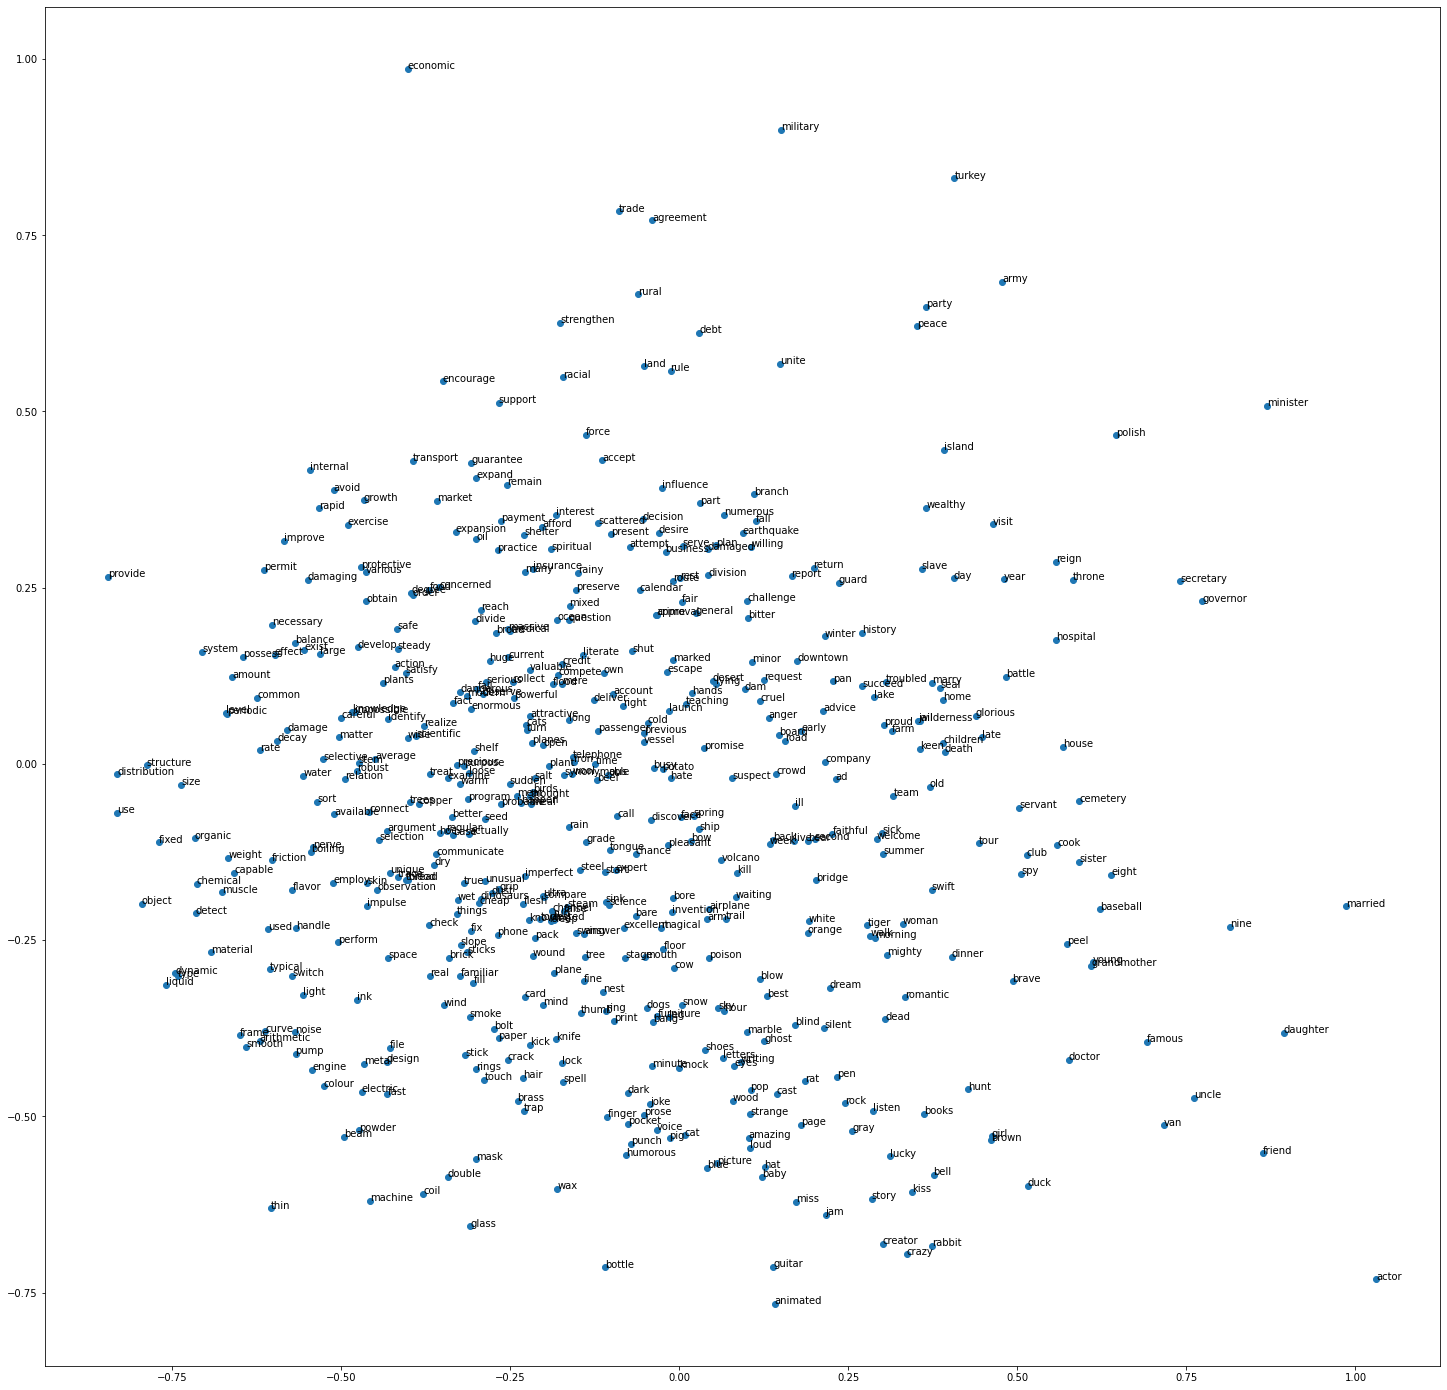

In [ ]:
draw(subset_representations_pca, words)

### Extra: Getting random words from internet

Generate and copy words from here. Then, paste to the notebook as a string.

https://www.randomlists.com/random-words?dup=false&qty=1000

In [ ]:
mystr = """quaint
raspy
gainful
heap
degree
vanish
defective
develop
pets
hair
pencil
colorful
notebook
false
jobless
daughter
beef
thought
realize
examine
many
route
impress
wail
juggle
curly
wilderness
snobbish
iron
actually
science
nebulous
yarn
jail
scarf
busy
pocket
unusual
chemical
promise
shaggy
flavor
sponge
elfin
harmonious
regular
quicksand
flesh
miss
oval
confuse
volcano
stupid
scent
back
succinct
rotten
acoustics
kettle
thaw
innate
marvelous
fortunate
engine
oranges
roomy
tree
toothsome
expansion
quartz
deliver
servant
wicked
receipt
marble
hulking
thirsty
perform
impolite
preserve
tricky
shaky
pushy
far-flung
roasted
handsome
crowd
panicky
steel
stir
squeak
electric
sick
happen
enormous
own
hellish
team
probable
kiss
flood
itchy
capable
shoes
top
strange
death
cat
rate
cats
abnormal
butter
brake
observation
shake
concerned
minister
kill
hour
decorous
lighten
gabby
tested
kindly
white
willing
lying
smoke
abounding
cow
ratty
steam
profuse
invention
noiseless
type
yell
cart
scream
jam
gaze
haunt
assorted
spoil
glamorous
slave
excite
rest
listen
smelly
rabid
picture
wind
spiteful
skate
pancake
zip
compete
influence
boundless
encourage
moan
purring
salty
writing
detect
mouth
peck
squealing
practice
maniacal
escape
excited
makeshift
suspend
pretend
minute
frighten
ocean
design
insurance
carpenter
acidic
bells
wide
sour
tramp
guitar
tidy
rapid
godly
succeed
rabbit
order
groovy
strengthen
teaching
stick
swift
bashful
jelly
necessary
remain
hunt
seed
mere
kick
interest
alert
bumpy
trousers
report
spiritual
old
wobble
spotted
fearless
dinner
laugh
wet
open
colour
animated
shoe
ghost
puffy
damaged
decay
snore
unite
thumb
goofy
mighty
cruel
tart
noxious
earthquake
blow
part
plan
deer
draconian
rhyme
beam
pack
walk
utter
thread
economic
puzzled
plants
leg
hideous
tasteless
hard-to-find
friend
coil
selfish
seal
stereotyped
guard
embarrassed
stem
nine
dust
industrious
imperfect
rule
purpose
scientific
grab
paper
land
peel
numerous
trace
curve
suspect
tightfisted
whimsical
well-groomed
tangy
ludicrous
morning
vessel
tray
laughable
selection
used
crate
tan
ritzy
unequal
late
cactus
frightening
afraid
time
snow
division
dolls
fascinated
liquid
huge
nappy
seemly
squalid
attempt
salt
mammoth
tub
lumber
squeeze
wool
endurable
trail
glove
knife
striped
sudden
better
pinch
pointless
lip
unfasten
overrated
icicle
rinse
amount
winter
trot
tedious
account
ink
ethereal
brash
object
dysfunctional
famous
base
accept
visit
orange
befitting
analyze
grandmother
current
dam
exultant
treat
company
tremble
divergent
slap
shelter
summer
reach
proud
girl
meal
pen
road
psychedelic
powerful
premium
curvy
absorbing
pie
hover
hilarious
satisfying
fast
second
fix
lyrical
loutish
versed
shelf
water
fill
marked
hands
fair
macabre
question
voice
mindless
advice
bell
synonymous
crazy
squeal
internal
force
twist
weight
glorious
maddening
ragged
action
curl
moldy
warm
wealthy
permit
lock
calm
creator
cheap
ship
icky
yawn
size
debonair
selective
amuse
tour
energetic
ugly
shut
fade
icy
double
bear
fax
channel
machine
paltry
fact
waiting
cluttered
structure
letters
dangerous
sink
crime
credit
oil
paddle
pleasant
spicy
bake
cumbersome
dark
barbarous
pickle
robust
shiver
hospital
brainy
painstaking
oafish
heartbreaking
married
bare
request
business
week
cracker
pricey
multiply
defiant
wiggly
literate
familiar
tangible
things
deserted
frame
beginner
cagey
jeans
lucky
erratic
uncle
onerous
miniature
boring
mask
bitter
discover
metal
delirious
well-made
nauseating
noise
precede
mist
breezy
mellow
sidewalk
thin
alluring
woozy
average
zebra
hug
previous
polish
phone
invite
keen
motionless
page
murky
lackadaisical
ubiquitous
nerve
spooky
dad
rot
matter
apathetic
lame
growth
fence
courageous
zealous
spotless
teeny
enchanting
fine
van
chew
complain
fireman
stranger
offend
cake
worthless
military
halting
run
eight
elated
dinosaurs
unkempt
furniture
digestion
ruthless
party
system
racial
telephone
lively
secretary
amazing
farm
clammy
womanly
fixed
coordinated
meaty
challenge
face
glow
beg
thunder
lake
pizzas
baseball
reign
excellent
fail
garrulous
children
well-off
vengeful
friction
intend
prickly
trite
touch
anxious
workable
throne
adamant
damage
cabbage
thinkable
broad
downtown
sister
trees
ring
clumsy
sock
mixed
turkey
observe
punch
truculent
advertisement
thank
likeable
pump
shrug
toys
massive
best
wound
general
check
illustrious
planes
right
crack
pan
blink
present
tiger
bawdy
tired
dispensable
grip
welcome
vase
story
valuable
swing
torpid
flawless
crib
soggy
troubled
earthy
magical
scandalous
marry
discreet
modern
use
protective
weary
frog
sneeze
stocking
grouchy
impossible
call
young
windy
spiffy
comb
anger
blood
brave
blue
early
real
perpetual
mind
army
satisfy
volatile
tire
identify
abusive
common
launch
poke
switch
wretched
cemetery
trade
permissible
belligerent
puny
upbeat
cast
irate
mend
hang
languid
flippant
bucket
rural
joke
organic
hum
balance
spell
brown
unpack
wax
live
unequaled
skin
stitch
poison
embarrass
dream
desire
thundering
frightened
glass
stage
disgusted
hydrant
afford
mundane
hysterical
lazy
suck
bang
level
handle
doll
cobweb
oceanic
tent
able
expand
wholesale
fanatical
horrible
space
approval
ill
retire
peace
impulse
slope
trap
sleep
prick
forgetful
boiling
bolt
ruin
plant
lonely
brass
silent
available
grandiose
second-hand
romantic
sticks
vagabond
grumpy
unadvised
choke
silly
shade
rainy
memorize
handsomely
ceaseless
jealous
finger
caption
decision
exuberant
stare
temper
passenger
effect
support
whirl
damaging
plane
duck
books
rat
noisy
clever
melt
sofa
fall
thoughtless
lowly
wander
superficial
copper
rabbits
meat
parsimonious
program
bait
home
testy
start
heady
soothe
moor
rude
glib
brick
governor
expert
club
bleach
squirrel
envious
elastic
badge
eyes
bow
quilt
loud
serious
payment
snatch
woman
smooth
exist
dashing
house
desert
obscene
precious
shave
elbow
teeny-tiny
careful
agreement
quixotic
ossified
return
ad hoc
quirky
petite
blind
ducks
powder
afterthought
stimulating
turn
childlike
observant
answer
milky
pig
history
wasteful
faithful
obtain
rock
admire
efficacious
wood
hat
voracious
wary
knot
possess
naive
jumpy
grade
unnatural
buzz
bottle
medical
needle
materialistic
hobbies
rhetorical
exercise
nest
thoughtful
actor
idiotic
baby
agonizing
file
loose
phobic
spy
safe
tongue
island
devilish
gray
pop
potato
airplane
board
depressed
dead
volleyball
ultra
true
knowing
foolish
old-fashioned
skip
flashy
dynamic
cooing
arithmetic
material
relation
muscle
grease
zany
minor
instinctive
employ
steady
large
rings
scattered
poised
faint
warn
argument
amusement
print
spring
dry
cold
straw
furry
ugliest
transport
divide
humorous
berserk
awesome
rain
disillusioned
arm
stormy
celery
prose
various
knowledge
long
day
floor
pies
bridge
flap
connect
bore
collect
debt
battle
attractive
ill-informed
calendar
snakes
avoid
card
outrageous
compare
chance
jellyfish
food
overt
cook
guarantee
grape
typical
stale
serve
inject
trashy
branch
communicate
snails
capricious
glue
blush
jaded
doctor
loaf
distribution
fallacious
bikes
year
float
collar
provide
breakable
seashore
sort
terrify
scarce
jog
parcel
overflow
unsuitable
obsequious
hate
festive
knock
improve
abashed
achiever
dogs
dear
unique
market
glistening
birds
sky
periodic
light"""

"degree","develop","hair","false","daughter","beef","thought","realize","examine","many","route","wilderness","iron","actually","science","jail","busy","pocket","unusual","chemical","promise","flavor","regular","flesh","miss","volcano","back","engine","tree","expansion","deliver","servant","marble","perform","preserve","crowd","steel","electric","sick","happen","enormous","own","team","probable","kiss","flood","capable","shoes","top","strange","death","cat","rate","cats","observation","concerned","minister","kill","hour","tested","white","willing","lying","smoke","cow","steam","invention","type","jam","slave","rest","listen","picture","wind","compete","influence","encourage","writing","detect","mouth","practice","escape","minute","ocean","design","insurance","wide","guitar","rapid","succeed","rabbit","order","strengthen","teaching","stick","swift","necessary","remain","hunt","seed","mere","kick","interest","report","spiritual","old","dinner","wet","open","colour","animated","ghost","da

In [ ]:
wl = [item for item in mystr.split() if item in dictionary.keys()]
len(wl)

for item in wl:
  print(f'"{item}",',end='')

## Bring the most similar words

Below we create a temporary model just to use for prediction purposes which only uses embedding and cosine similarity by dot product.

In [ ]:
similarity = dot([target, context], normalize=True, axes=1)
validation_model = Model(inputs=[input_target, input_context], outputs=similarity)


In [ ]:
valid_size = 16 
valid_window = 100
valid_examples = np.random.choice(valid_window, valid_size, replace=False)

class SimilarityCallback:
    def run_sim(self):
        for i in range(valid_size):
            valid_word = inverse_dictionary[valid_examples[i]]
            top_k = 8  # number of nearest neighbors
            sim = self._get_sim(valid_examples[i])
            nearest = (-sim).argsort()[1:top_k + 1]
            log_str = 'Nearest to %s:' % valid_word
            for k in range(top_k):
                close_word = inverse_dictionary[nearest[k]]
                log_str = '%s %s,' % (log_str, close_word)
            print(log_str)

    @staticmethod
    def _get_sim(valid_word_idx):
        sim = np.zeros((vocabulary_upper_limit,))
        in_arr1 = np.zeros((1,))
        in_arr2 = np.zeros((1,))
        in_arr1[0,] = valid_word_idx
        for i in range(vocabulary_upper_limit):
            in_arr2[0,] = i
            out = validation_model.predict_on_batch([in_arr1, in_arr2])
            sim[i] = out
        return sim

In [ ]:
sim_cb = SimilarityCallback()


In [ ]:
sim_cb.run_sim()

Nearest to two: three, one, zero, five, four, eight, six, seven,
Nearest to many: some, other, these, and, have, such, of, are,
Nearest to their: the, to, and, of, some, in, its, other,
Nearest to also: the, and, of, in, see, as, to, that,
Nearest to as: and, the, of, a, in, is, to, for,
Nearest to is: the, a, and, in, of, was, as, to,
Nearest to not: but, the, and, as, that, would, to, is,
Nearest to or: and, the, of, in, as, a, is, to,
Nearest to while: and, in, the, as, of, or, a, however,
Nearest to UNKNOWN: trail, marketing, famed, actors, fine, pace, screen, keith,
Nearest to a: the, and, of, is, in, as, to, was,
Nearest to be: can, is, are, it, was, may, as, being,
Nearest to during: after, in, was, the, early, since, however, this,
Nearest to th: century, nd, rd, eighth, nineteenth, centuries, twentieth, sixth,
Nearest to first: the, a, in, one, as, and, of, also,
Nearest to system: systems, operating, based, but, also, a, which, is,


## Unused

In [ ]:
import plotly
import numpy as np
import plotly.graph_objs as go
from sklearn.manifold import TSNE

def display_tsne_scatterplot_3D(model, user_input=None, words=None, label=None, color_map=None, topn=5, sample=100):

    if words == None:
        if sample > 0:
            words = np.random.choice(list(model.keys()), sample)
        else:
            words = [ word for word in model.keys() ]
    
    # import pdb
    # pdb.set_trace()
    word_vectors = np.array([model[w] for w in words])
    
    three_dim = TSNE(n_components = 3).fit_transform(word_vectors)[:,:3]


    # For 2D, change the three_dim variable into something like two_dim like the following:
    # two_dim = TSNE(n_components = 2, random_state=0, perplexity = perplexity, learning_rate = learning_rate, n_iter = iteration).fit_transform(word_vectors)[:,:2]

    data = []


    count = 0
    for i in range (len(user_input)):

                trace = go.Scatter3d(
                    x = three_dim[count:count+topn,0], 
                    y = three_dim[count:count+topn,1],  
                    z = three_dim[count:count+topn,2],
                    text = words[count:count+topn],
                    name = user_input[i],
                    textposition = "top center",
                    textfont_size = 20,
                    mode = 'markers+text',
                    marker = {
                        'size': 10,
                        'opacity': 0.8,
                        'color': 2
                    }
       
                )
                
                # For 2D, instead of using go.Scatter3d, we need to use go.Scatter and delete the z variable. Also, instead of using
                # variable three_dim, use the variable that we have declared earlier (e.g two_dim)
            
                data.append(trace)
                count = count+topn

    trace_input = go.Scatter3d(
                    x = three_dim[count:,0], 
                    y = three_dim[count:,1],  
                    z = three_dim[count:,2],
                    text = words[count:],
                    name = 'input words',
                    textposition = "top center",
                    textfont_size = 20,
                    mode = 'markers+text',
                    marker = {
                        'size': 10,
                        'opacity': 1,
                        'color': 'black'
                    }
                    )

    # For 2D, instead of using go.Scatter3d, we need to use go.Scatter and delete the z variable.  Also, instead of using
    # variable three_dim, use the variable that we have declared earlier (e.g two_dim)
            
    data.append(trace_input)
    
# Configure the layout

    layout = go.Layout(
        margin = {'l': 0, 'r': 0, 'b': 0, 't': 0},
        showlegend=True,
        legend=dict(
        x=1,
        y=0.5,
        font=dict(
            family="Courier New",
            size=25,
            color="black"
        )),
        font = dict(
            family = " Courier New ",
            size = 15),
        autosize = False,
        width = 1000,
        height = 1000
        )


    plot_figure = go.Figure(data = data, layout = layout)
    plot_figure.show()


#user_input = ['man','woman','girl','boy','prince','princess','doctor','teacher', 'scientist','president' ]
#vis_words = ["mind", "root", "machine", "bridge", "board", "planes", "engine", "stretch", "pet", "arm", "wax", "table", "cow", "sister", "land", "houses", "street",  "metal", "knife",  "tongue", "can",  "fly" ]
#vis_words = ['man','woman' ]
user_input = ['man','woman']
display_tsne_scatterplot_3D(word2vector, user_input, topn = 5)